In [40]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA

# 0. Preprocessing and Reading Data

In [57]:
patient = 5
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")

# Remove Empty Rows
zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmSeries = cgmSeries[zero_entries == False]
insulinBasal = insulinBasal[zero_entries == False]
insulinBolus = insulinBolus[zero_entries == False]
insulinTime = insulinTime[zero_entries == False]

In [58]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

# 1.a Anirudh Features

In [59]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append(slope)
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [60]:
# Regression Error
reg_window_size = 4
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        if np.isnan(times).any():
            errors = np.append(errors, -1)
            continue
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    while(len(values) < 2):
        values = np.append(values, 0)
        heights = np.append(heights, 0)
        times = np.append(times, 0)
        times2 = np.append(times2, 0)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

12.000000044703484
0.08333333302289248


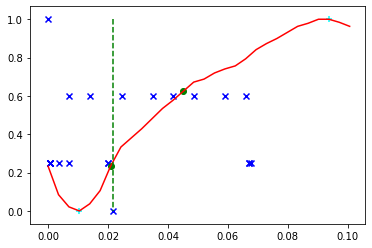

[0.62433862 0.23280423]
[0.04497355 0.13227514]
[0.04513889 0.02083333]


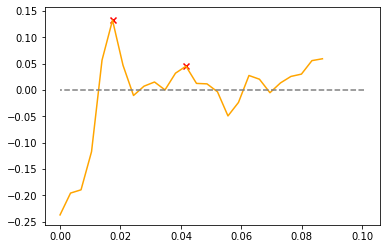

41.14285624513822
0.02430555608589202


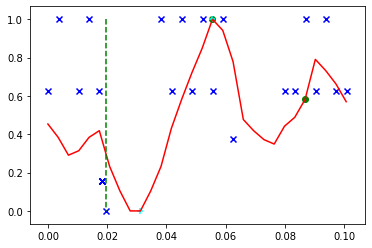

[0.58139535 1.        ]
[0.43217055 0.58139536]
[0.08680556 0.05555556]


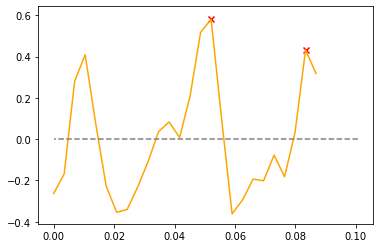

9.931034523581777
0.1006944440305233


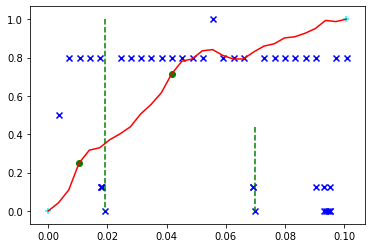

[0.71341463 0.25      ]
[0.10467479 0.14735772]
[0.04166667 0.01041667]


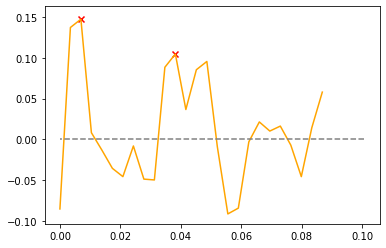

10.285714307609869
0.09722222201526165


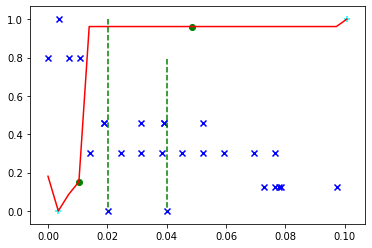

[0.96190476 0.15238095]
[4.44089210e-16 8.76190476e-01]
[0.04861111 0.01041667]


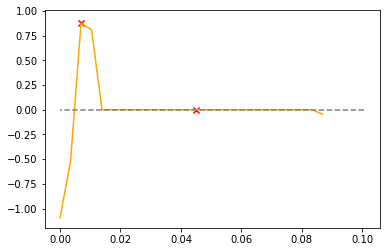

9.931034431729673
0.10069444496184587


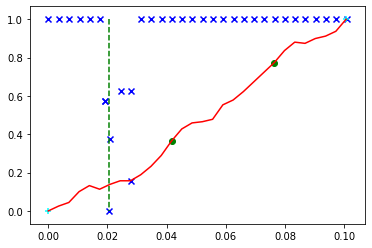

[0.77358491 0.36477987]
[0.08385745 0.1048218 ]
[0.07638889 0.04166667]


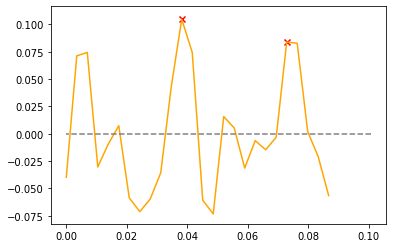

0.0
0.0


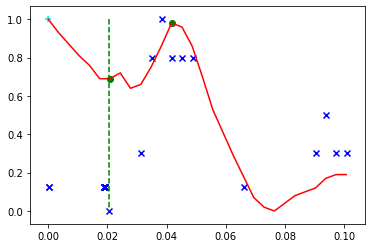

[0.69 0.98]
[0.07333333 0.37000004]
[0.02083333 0.04166667]


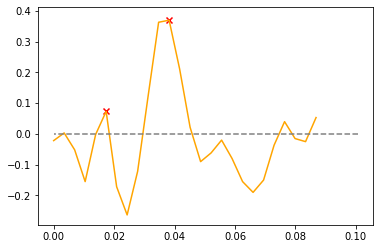

19.20000011444092
0.052083333022892475


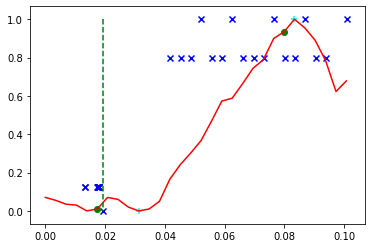

[0.01005025 0.93467337]
[0.12562815 0.21440538]
[0.01736111 0.07986111]


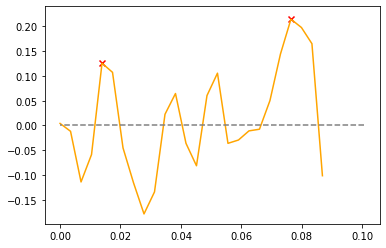

12.521739164913084
0.0798611108912155


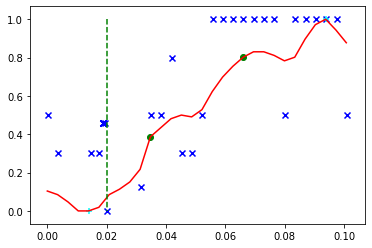

[0.80188679 0.38679245]
[0.09748428 0.15566037]
[0.06597222 0.03472222]


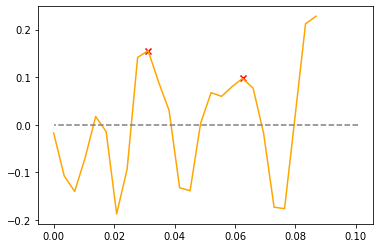

11.519999929618836
0.08680555608589202


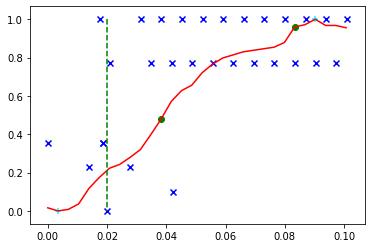

[0.47773279 0.95951417]
[0.09379216 0.10728745]
[0.03819444 0.08333333]


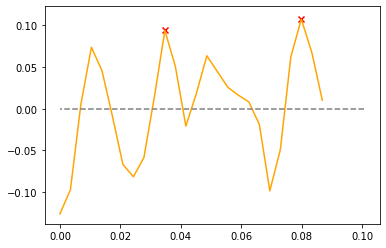

15.157894570411408
0.06597222294658422


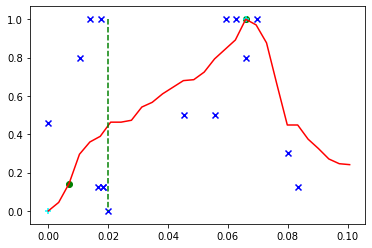

[0.14285714 1.        ]
[0.1633826  0.40968807]
[0.00694445 0.06597222]


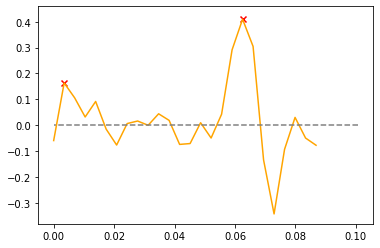

32.0
0.03125


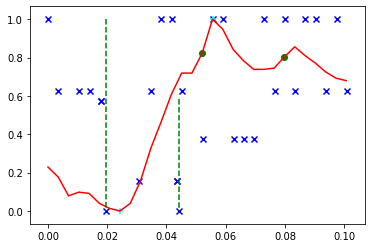

[0.80392157 0.82352941]
[0.1949891  0.44662312]
[0.07986111 0.05208333]


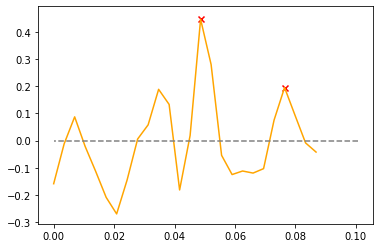

15.999999999999996
0.0625


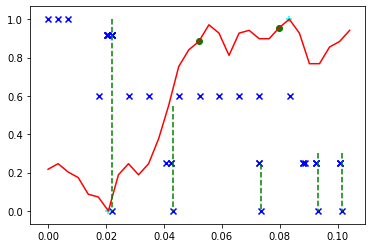

[0.88405797 0.95652174]
[0.30193239 0.34782612]
[0.05208333 0.07986111]


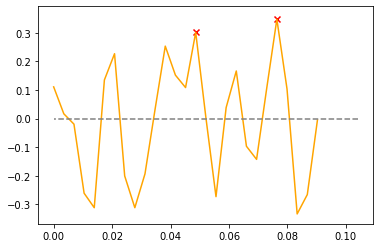

0.0
0.0


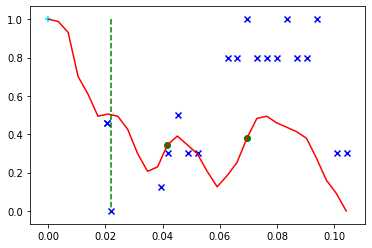

[0.34482759 0.37931034]
[0.25287358 0.2605364 ]
[0.04166667 0.06944444]


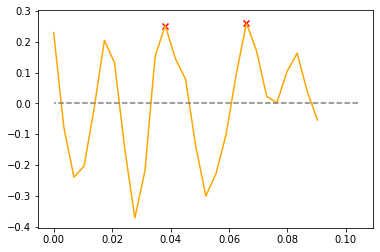

0.0
0.0


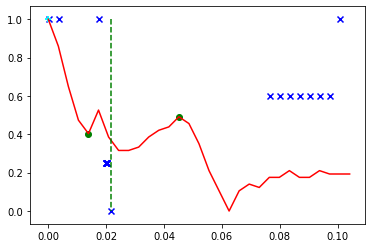

[0.40350877 0.49122807]
[0.25146197 0.26900582]
[0.01388889 0.04513889]


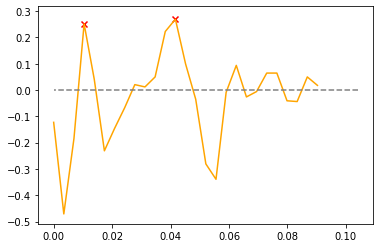

19.200000157356264
0.05208333290647715


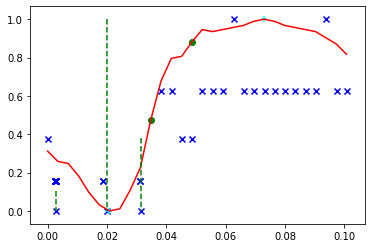

[0.88172043 0.47311828]
[0.13620072 0.34050179]
[0.04861111 0.03472222]


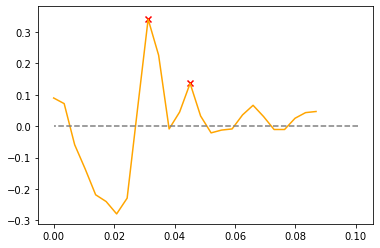

11.999999893829228
0.08333333407063037


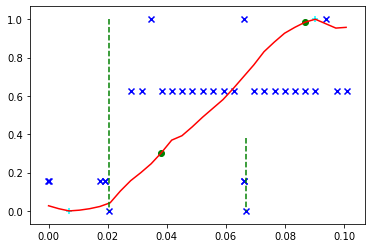

[0.30384615 0.98461538]
[0.05000001 0.08846155]
[0.03819444 0.08680556]


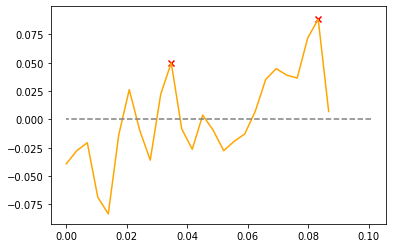

13.09090905322516
0.0763888891087845


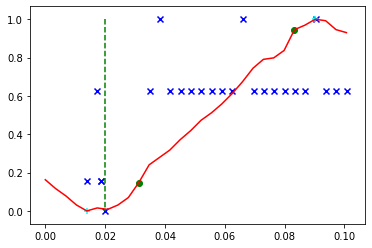

[0.14728682 0.94573643]
[0.09302325 0.11498708]
[0.03125    0.08333333]


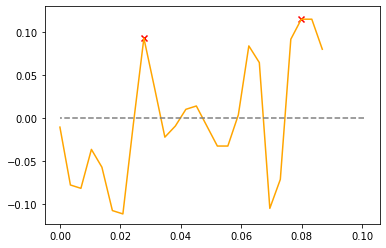

10.285714307609869
0.09722222201526165


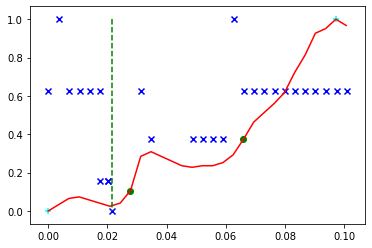

[0.37398374 0.10569106]
[0.07317072 0.25203252]
[0.06597222 0.02777778]


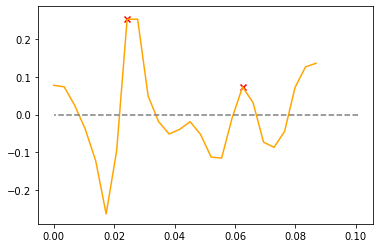

In [61]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()    

# 1.b Vedant Features

In [62]:
# Windowed features
window_mins = []
window_maxs = []
window_means = []
window_vars = []
for i in range(0, len(cgmSeries_np)):
    window_input = DataFrame(cgmNorm_np[i][::-1])
    width=5
    shifted=window_input.shift(width - 1)
    window=shifted.rolling(window=width)
    dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
    dataframe.columns = ['var', 'min', 'mean', 'max']
    window_features = dataframe.nlargest(2,'var')
    window_values = window_features.values
    window_mins.append([window_values[0][1], window_values[1][1]])
    window_maxs.append([window_values[0][3], window_values[1][3]])
    window_vars.append([window_values[0][0], window_values[1][0]])
    window_means.append([window_values[0][2], window_values[1][2]])

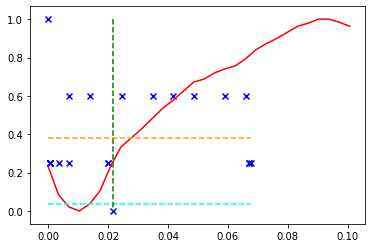

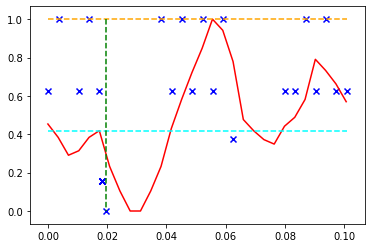

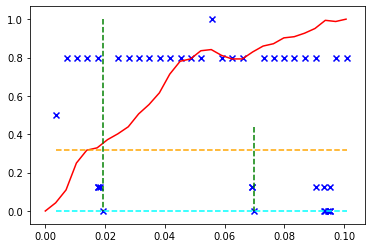

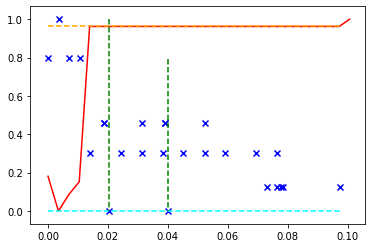

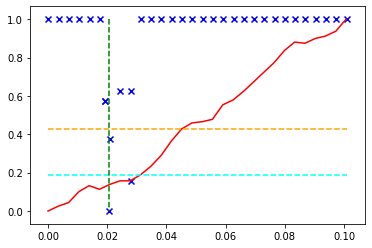

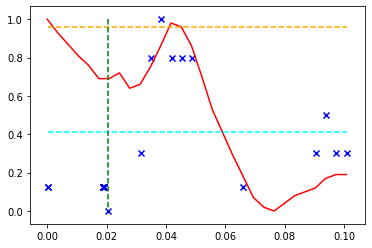

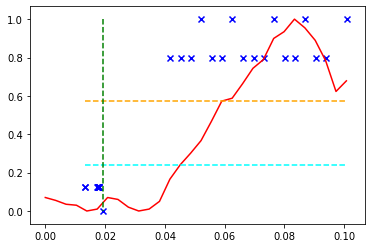

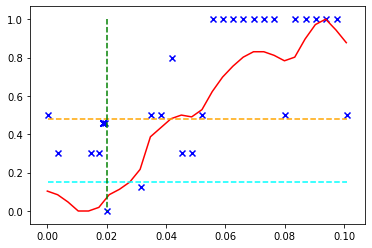

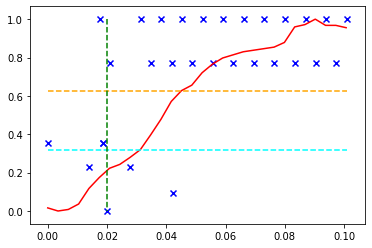

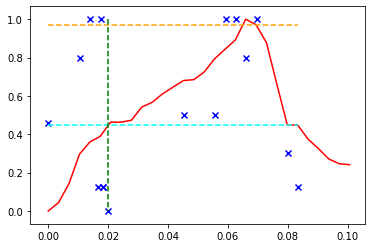

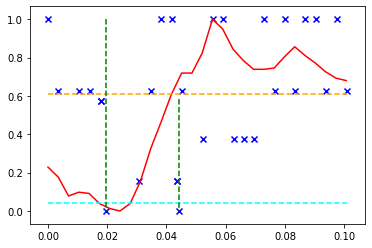

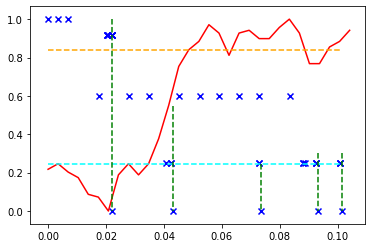

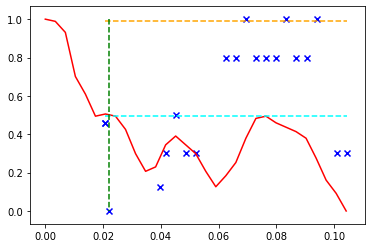

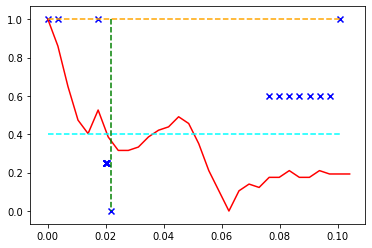

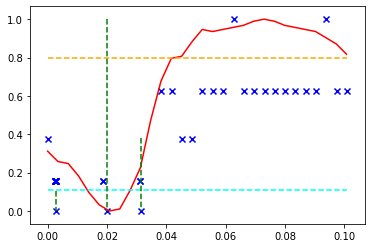

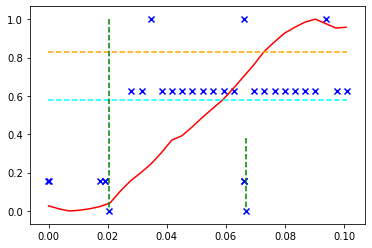

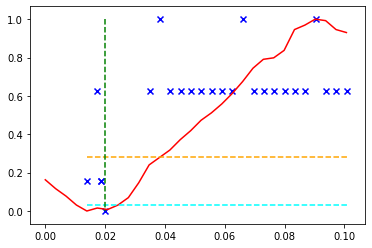

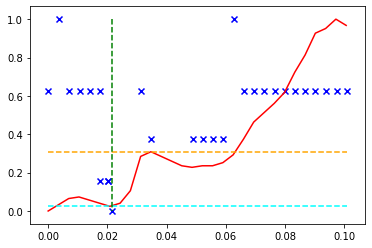

In [63]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    po1 = np.nanmin(insulinTime_np[i])
    po2 = np.nanmax(insulinTime_np[i])
    plt.plot([po1, po2], [window_mins[i][0], window_mins[i][0]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][0], window_maxs[i][0]], c='orange', linestyle='dashed')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()

# 1.c Omkar Features

In [64]:
# series = cgmNorm_np
# datenum = cgmSeries_np
# InsulinBolus = insulinBolusNorm_np
# InsulinTimestamp = insulinTime_np

In [65]:
maximum=[]
for i in range(insulinBolusNorm_np[:,0].size):
    maximum.append(np.nanargmax(insulinBolusNorm_np[i]))
# print(maximum)

In [66]:
def slope(time,values):
    slope = []
    for i in range(len(values)-1):
        slope.append((values[i+1]-values[i])/(time[i+1]-time[i])) 
    slope.append(np.nan)
    slope = np.asarray(slope)
    
    return slope

0.5955320399764844


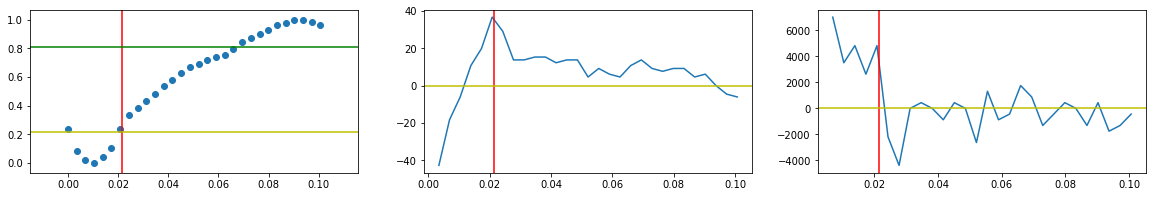

0.3006008679203295


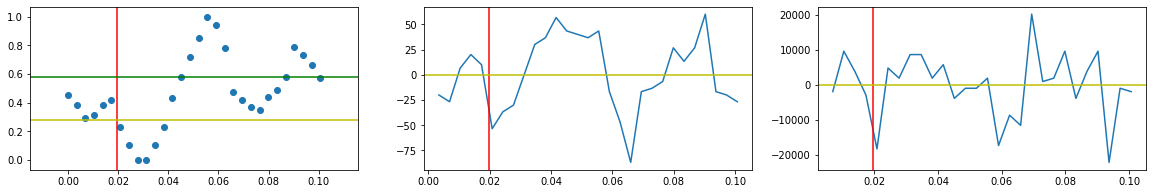

0.610248447204969


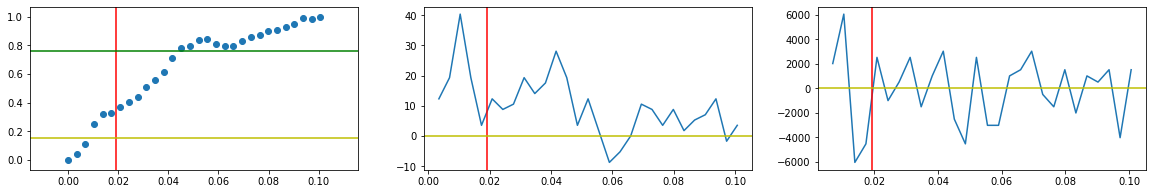

0.7015873015873015


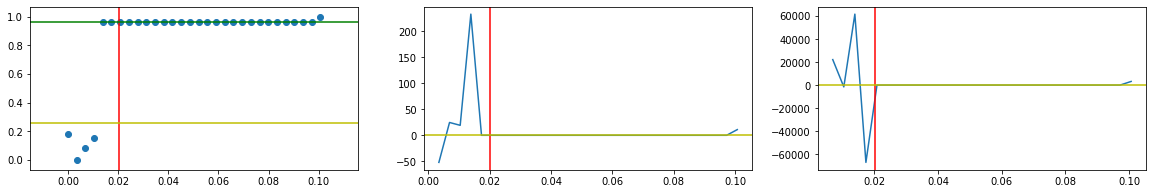

0.48951130903550916


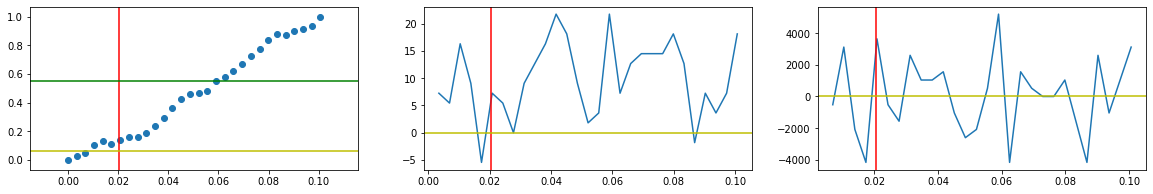

-0.4200000000000001


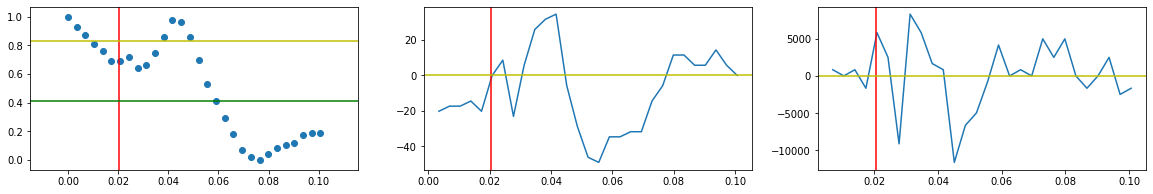

0.48225253250378874


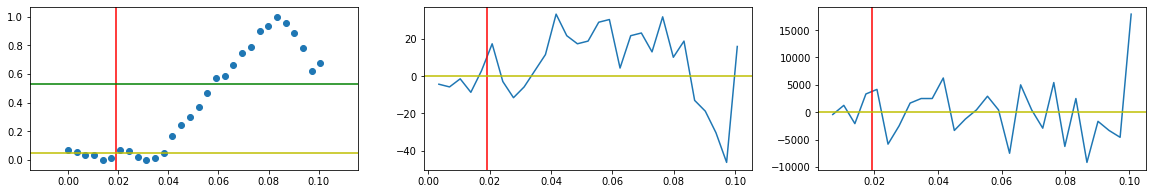

0.6299539586530649


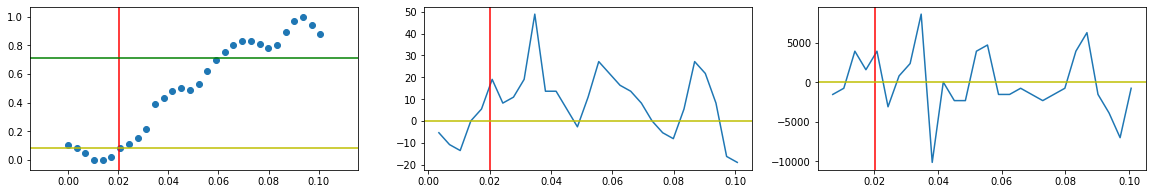

0.6180317658050452


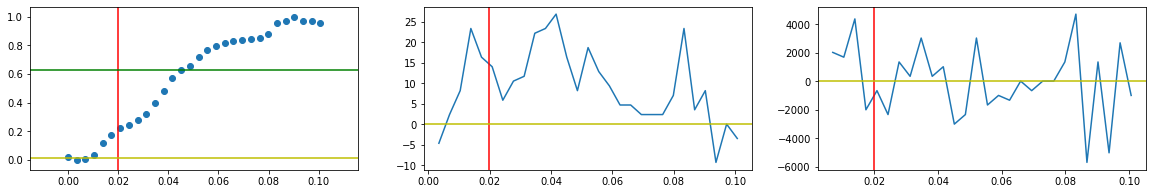

0.4591543513957307


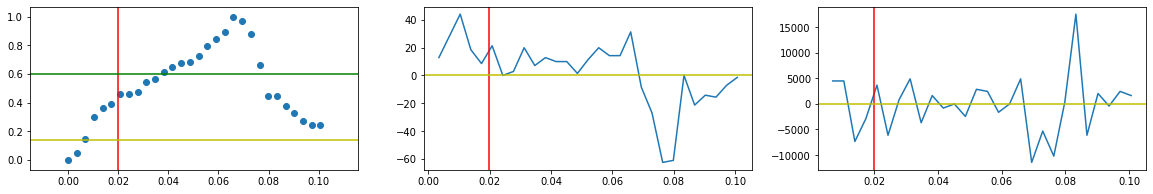

0.4162091503267974


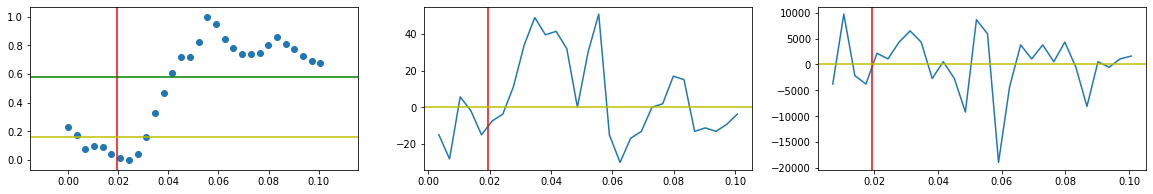

0.6204278812974465


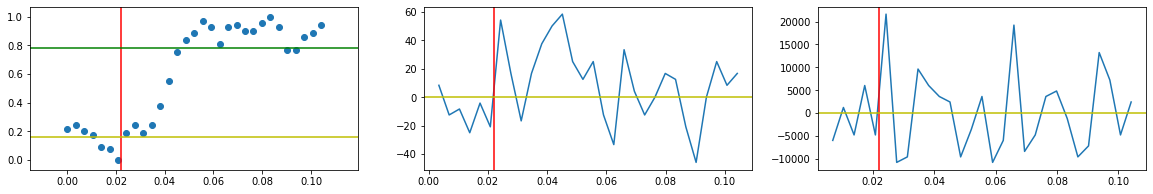

-0.5996829171621084


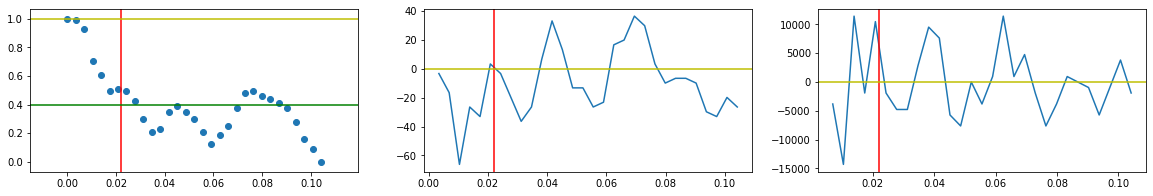

-0.306321358952938


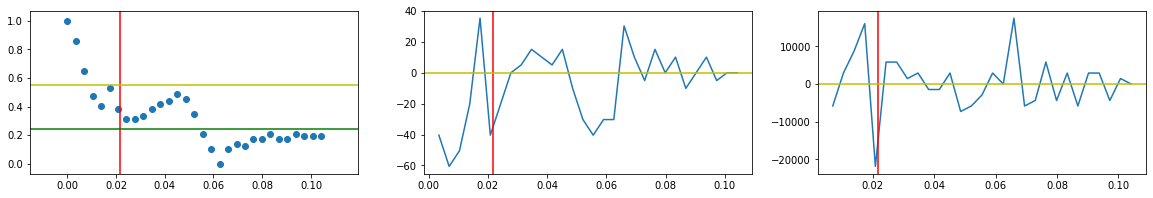

0.7296393476359521


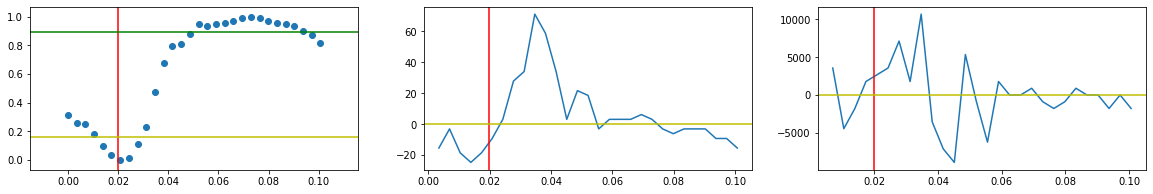

0.5031804733727812


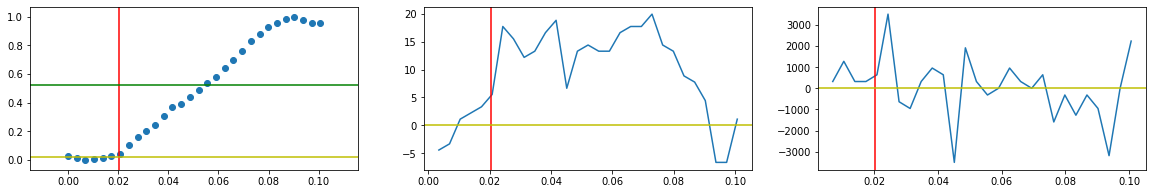

0.3290267011197243


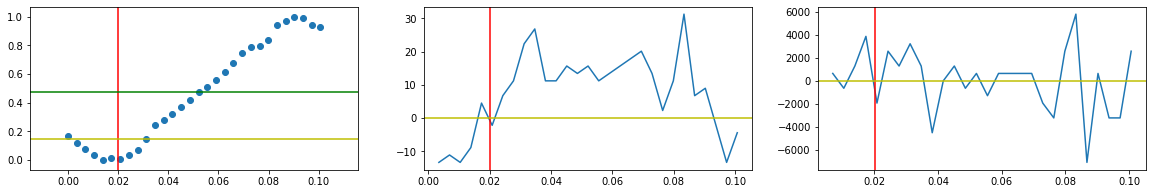

0.4046563192904657


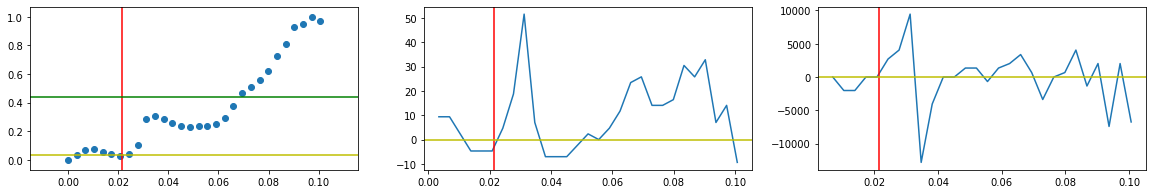

[0.5955320399764844, 0.3006008679203295, 0.610248447204969, 0.7015873015873015, 0.48951130903550916, -0.4200000000000001, 0.48225253250378874, 0.6299539586530649, 0.6180317658050452, 0.4591543513957307, 0.4162091503267974, 0.6204278812974465, -0.5996829171621084, -0.306321358952938, 0.7296393476359521, 0.5031804733727812, 0.3290267011197243, 0.4046563192904657]


In [67]:
mean_before = []
mean_after = []
mean_dif = []
for i in range(0,len(cgmNorm_np)):
    fig = plt.figure(figsize=(20,3))
    
    sl = slope(cgmSeries_np[i],cgmNorm_np[i])
    
    
    sl_1 = slope(cgmSeries_np[i],sl)
    sl_2 = slope(cgmSeries_np[i],sl_1)
    sl_3 = slope(cgmSeries_np[i],sl_2)
#     cut = insulinTime_np[i,maximum[i]]
#     print(maximum[i])
#     print(cut)
#     cut1 = np.where(insulinTime_np[i]==cut)
#     print(int(cut1[0]))
#     print(cut1)
    mean1 = np.nanmean(cgmNorm_np[i][-1:-maximum[i]:-1])
    mean2 = np.nanmean(cgmNorm_np[i][-maximum[i]:0:-1])
    
    mean_before.append(mean1)
    mean_after.append(mean2)
    
    print(mean2-mean1)
    
    plt.subplot(1,3,1)
    plt.scatter(cgmSeries_np[i],cgmNorm_np[i])
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = mean1,c='y')
    plt.axhline(y = mean2,c='g')
    
    plt.subplot(1,3,2)
    plt.plot(cgmSeries_np[i],sl)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    
    plt.subplot(1,3,3)
    plt.plot(cgmSeries_np[i],sl_1)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    plt.show()

mean_dif = [x - y for x, y in zip(mean_after, mean_before)]
print(mean_dif)

# 1.d Ananth Features

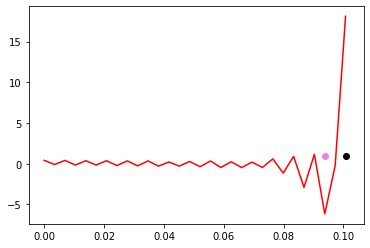

[18.11111111111111, -6.16890692998847, 0.33540114403354626, 12.169671348089839]


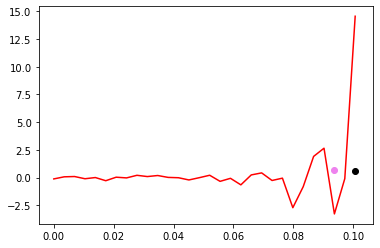

[14.558139534883722, -3.273537407408803, 0.37575346877225313, 7.68308225940291]


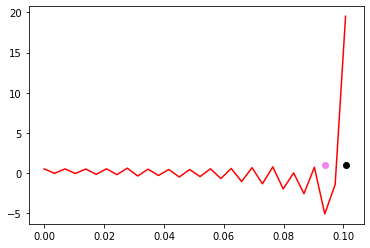

[19.530487804878057, -5.104806618008133, 0.3325855176418455, 13.713063736305374]


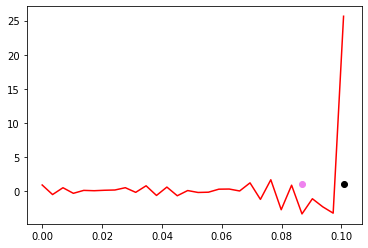

[25.647619047619052, -3.3778900813541424, 0.5177819236759869, 22.45537199874489]


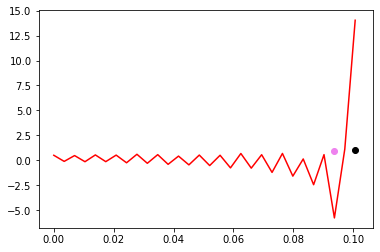

[14.037735849056602, -5.767966079785664, 0.24850618834344154, 7.925586947208143]


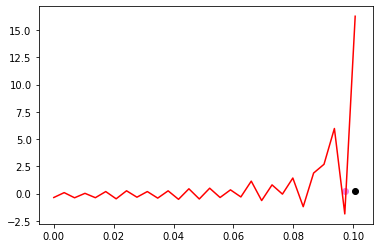

[16.27, -1.8716895037451442, 0.7913478807705434, 9.787981434825776]


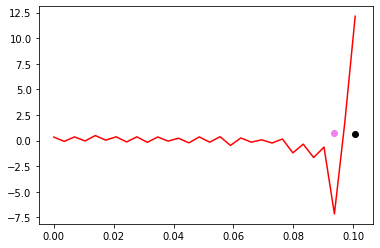

[12.14572864321608, -7.171432767850301, 0.1537011809179219, 6.702810030190219]


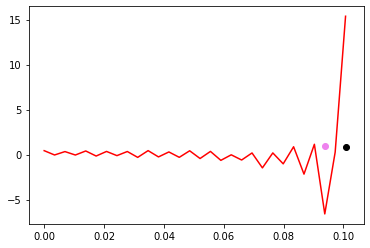

[15.367924528301884, -6.598128674542633, 0.22380729942451363, 9.383174914504526]


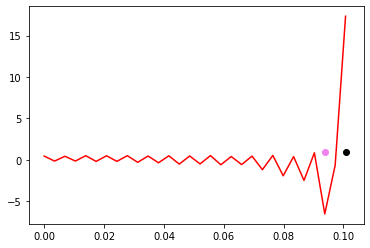

[17.327935222672064, -6.537839455464832, 0.24782541719906673, 11.547723255211343]


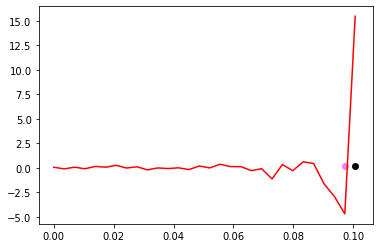

[15.472906403940886, -4.689835333344853, 0.22485955808683578, 8.82215076384484]


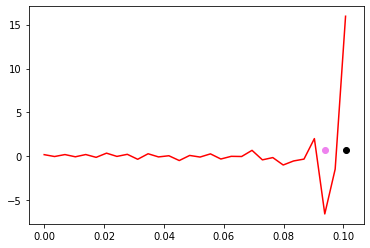

[15.947712418300656, -6.549171773991666, 0.2841979511959984, 9.801875227881418]


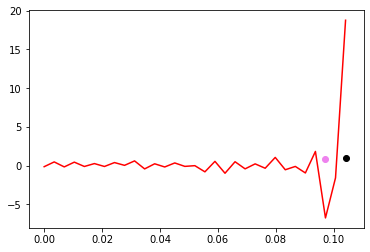

[18.753623188405797, -6.7478392393310305, 0.3874941943848158, 13.055274054414578]


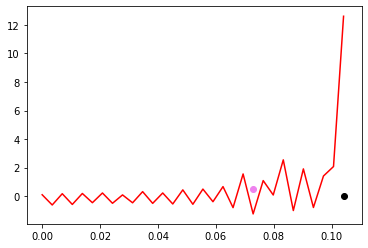

[12.60919540229885, -1.2433090079052955, 0.5725150666289932, 5.6877269054910125]


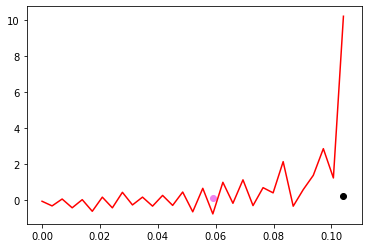

[10.192982456140347, -0.7789003880157936, 0.5944574644478848, 3.722345856376937]


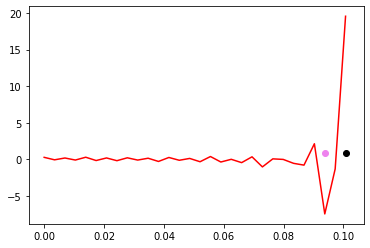

[19.5483870967742, -7.441636327770571, 0.356808422046806, 14.292672905801457]


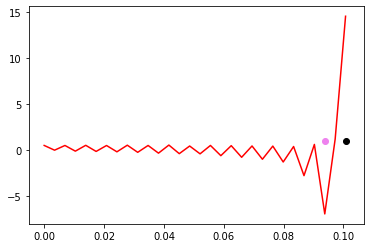

[14.530769230769232, -6.983298806963561, 0.20418649228955332, 8.887601634717324]


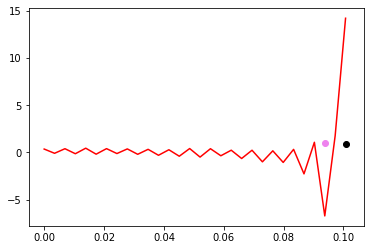

[14.23255813953488, -6.724991403204041, 0.2455242377099066, 8.393674361080876]


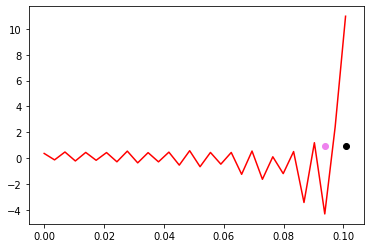

[10.967479674796744, -4.296657340555494, 0.18398650751697493, 5.366051736699405]


[[18.11111111111111,
  -6.16890692998847,
  0.33540114403354626,
  12.169671348089839],
 [14.558139534883722,
  -3.273537407408803,
  0.37575346877225313,
  7.68308225940291],
 [19.530487804878057,
  -5.104806618008133,
  0.3325855176418455,
  13.713063736305374],
 [25.647619047619052,
  -3.3778900813541424,
  0.5177819236759869,
  22.45537199874489],
 [14.037735849056602,
  -5.767966079785664,
  0.24850618834344154,
  7.925586947208143],
 [16.27, -1.8716895037451442, 0.7913478807705434, 9.787981434825776],
 [12.14572864321608,
  -7.171432767850301,
  0.1537011809179219,
  6.702810030190219],
 [15.367924528301884,
  -6.598128674542633,
  0.22380729942451363,
  9.383174914504526],
 [17.327935222672064,
  -6.537839455464832,
  0.24782541719906673,
  11.547723255211343],
 [15.472906403940886,
  -4.689835333344853,
  0.22485955808683578,
  8.82215076384484],
 [15.947712418300656,
  -6.549171773991666,
  0.2841979511959984,
  9.801875227881418],
 [18.753623188405797,
  -6.7478392393310305,


In [68]:
Feature_vector=[]
for i in range(0, len(cgmSeries_np)):
#FFT
    fastfouriertransform=rfft(cgmNorm_np[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], fastfouriertransform, c='red')
    fft_max=np.nanmax(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_max)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='black')
    fft_min=np.nanmin(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_min)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='violet')
    fft_mean=np.nanmean(fastfouriertransform)
    fft_variance=np.nanvar(fastfouriertransform)
    Feature_vector.append([fft_max,fft_min,fft_mean,fft_variance])
    plt.show()
    print([fft_max,fft_min,fft_mean,fft_variance])
display(Feature_vector)   

# 2. Generating Feature Matrix, Visualizing Spread and PCA

In [69]:
# Feature Matrix
matrix = []
for i in range(0, len(cgmSeries_np)):
    matrix_row = np.array([])
    # Anirudh
    matrix_row = np.append(matrix_row, slopes[i])
    matrix_row = np.append(matrix_row, time_diffs[i])
    matrix_row = np.append(matrix_row, peak_values[i])
    matrix_row = np.append(matrix_row, peak_heights[i])
    matrix_row = np.append(matrix_row, peak_times[i])
    # Vedant
    matrix_row = np.append(matrix_row, window_mins[i])
    matrix_row = np.append(matrix_row, window_maxs[i])
    matrix_row = np.append(matrix_row, window_vars[i])
    matrix_row = np.append(matrix_row, window_means[i])
    # Omkar
    matrix_row = np.append(matrix_row, mean_before[i])
    matrix_row = np.append(matrix_row, mean_after[i])
    matrix_row = np.append(matrix_row, mean_dif[i])
    # Ananth
    matrix_row = np.append(matrix_row, Feature_vector[i])
    if len(matrix) == 0:
        matrix = np.array([matrix_row])
    else:
        matrix = np.append(matrix, [matrix_row], axis=0)
       
matrix = np.nan_to_num(matrix)
# Normalizing Values
transformer = pre.FunctionTransformer(np.log1p, validate=True)
matrix = transformer.transform(matrix)
matrix = np.nan_to_num(matrix)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:179: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


In [70]:
# Converting to dataframe for easy visualization
columns = ['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Mean_before', 'Mean_after', 'Mean_diff',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ]
feature_df = pd.DataFrame(matrix, columns=columns)
display(feature_df)

,Slope_minmax,TimeDiff_minmax,PeakVal1_error,PeakVal2_error,PeakHt1_error,PeakHt2_error,PeakTime1_error,PeakTime2_error,Min1_window,Min2_window,...,Var2_window,Mean1_window,Mean2_window,Mean_before,Mean_after,Mean_diff,Max_fft,Min_fft,Mean_fft,Var_fft
0,2.564949,0.080043,0.485101,0.209291,4.399157e-02,0.124229,0.044150,0.020619,0.036368,0.000000,...,0.019151,0.197201,0.132605,0.194156,0.593226,0.467207,2.950270,0.000000,0.289232,2.577917
1,3.741065,0.024015,0.458308,0.693147,3.591912e-01,0.458308,0.083243,0.054067,0.349674,0.099530,...,0.060885,0.544215,0.346390,0.243651,0.455207,0.262826,2.744584,0.000000,0.319002,2.161377
2,2.391606,0.095941,0.538488,0.223144,9.955098e-02,0.137462,0.040822,0.010363,0.000000,0.041797,...,0.016201,0.134446,0.190419,0.139610,0.565356,0.476388,3.021911,0.000000,0.287121,2.688736
3,2.423538,0.092782,0.673916,0.141830,4.440892e-16,0.629243,0.047467,0.010363,0.000000,0.082238,...,0.193655,0.359338,0.485361,0.231364,0.673916,0.531562,3.282700,0.000000,0.417250,3.155100
4,2.391606,0.095941,0.573003,0.310993,8.052639e-02,0.099684,0.073612,0.040822,0.172843,0.209210,...,0.008833,0.262848,0.303593,0.057608,0.437487,0.398448,2.710563,0.000000,0.221948,2.188922
5,0.000000,0.000000,0.524729,0.683097,7.076907e-02,0.314811,0.020619,0.040822,0.343590,0.254642,...,0.050189,0.525911,0.443403,0.604316,0.343590,-0.544727,2.848971,0.000000,0.582968,2.378433
6,3.005683,0.050772,0.010000,0.659939,1.183412e-01,0.194255,0.017212,0.076832,0.216084,0.263523,...,0.015617,0.329268,0.377954,0.043699,0.423253,0.393563,2.576097,0.000000,0.142975,2.041585
7,2.604299,0.076832,0.588834,0.326993,9.302054e-02,0.144672,0.063887,0.034133,0.140582,0.107246,...,0.020202,0.288154,0.231411,0.080702,0.538831,0.488552,2.795324,0.000000,0.201967,2.340187
8,2.527327,0.083243,0.390509,0.672697,8.965071e-02,0.101913,0.037483,0.080043,0.277509,0.246354,...,0.013860,0.391057,0.342814,0.010071,0.487446,0.481210,2.908426,0.000000,0.221402,2.529539
9,2.782409,0.063887,0.133531,0.693147,1.513318e-01,0.343368,0.006920,0.063887,0.370374,0.370374,...,0.053030,0.519263,0.582848,0.131374,0.469721,0.377857,2.801717,0.000000,0.202826,2.284640


/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


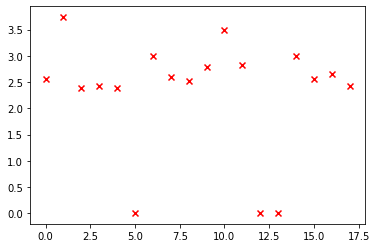

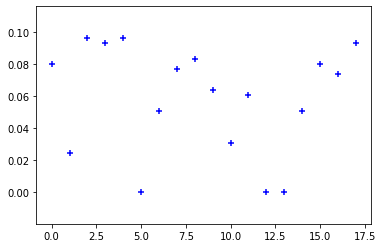

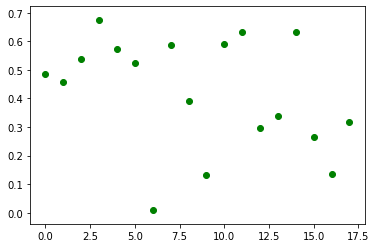

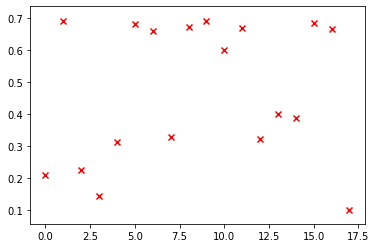

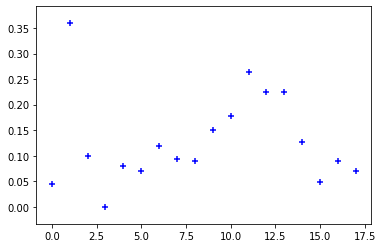

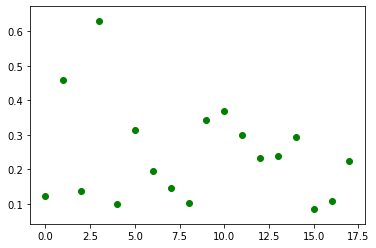

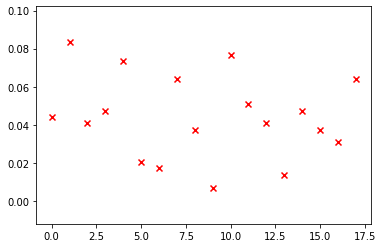

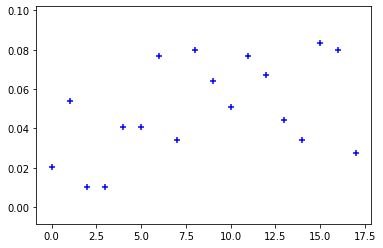

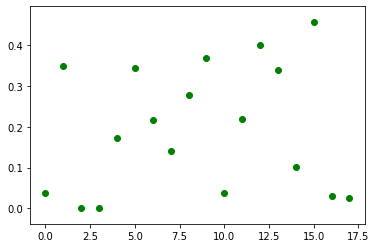

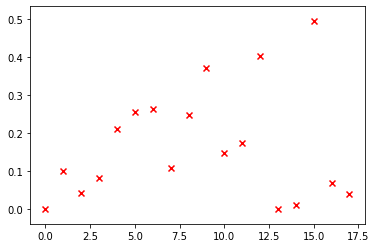

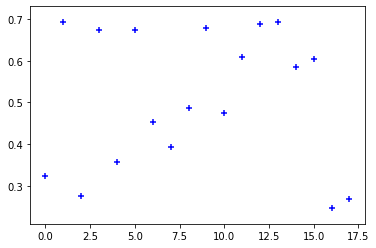

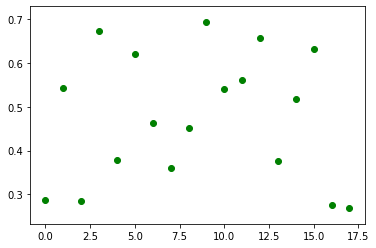

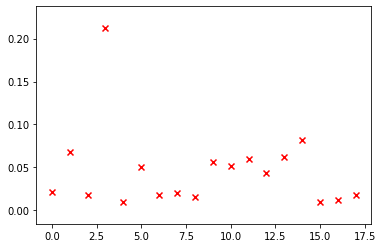

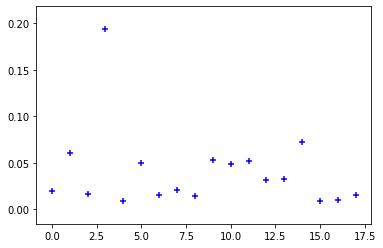

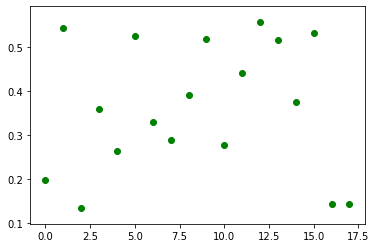

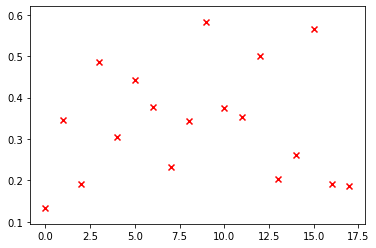

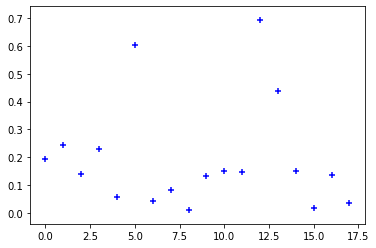

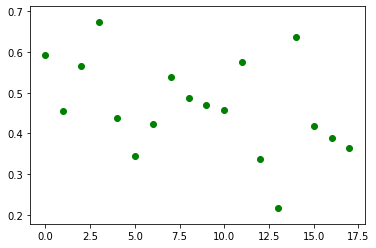

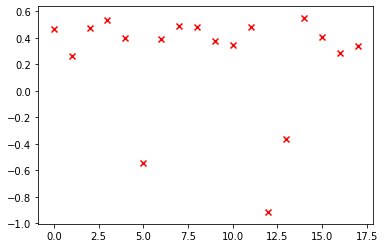

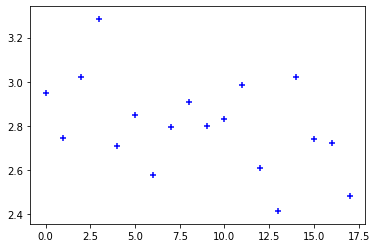

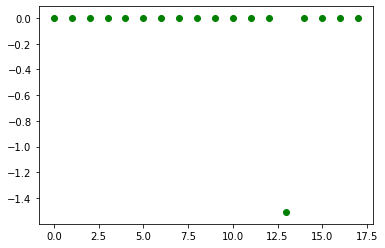

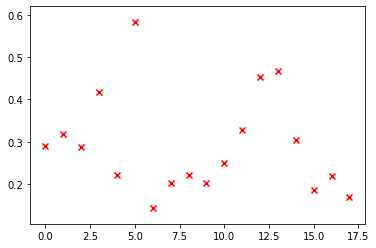

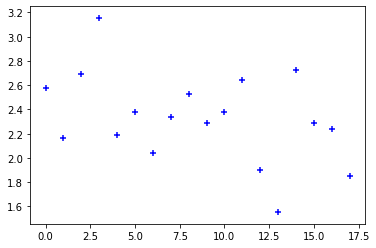

In [71]:
# Scatter Visualization
rows = [i for i in range(len(cgmNorm_np))]
colors = ['red', 'blue', 'green']
markers = ['x', '+', 'o']
for i in range(0, matrix.shape[1]):
    plt.figure()
    plt.scatter(rows, matrix[:, i], color=colors[i%3] ,marker=markers[i%3])
    # plt.show()
    # Save Images
    plt.savefig('Images/Patient' + str(patient) + '/' + columns[i] + '.png')

1.5135658740058622
[-9.04892232e-01 -1.70740771e-02 -2.04809557e-02 -2.22686036e-02
  4.15875619e-03 -9.25396659e-03 -8.28739697e-03 -3.67902152e-04
  5.59628653e-02  2.08886853e-02  4.88803977e-02  1.53152754e-02
 -9.65273907e-05 -2.88454574e-03  5.08881787e-02  1.15367962e-02
  1.30762642e-01 -6.26815610e-02 -3.05399775e-01 -6.96323868e-02
 -1.59490329e-01  7.06052823e-02 -1.45947056e-01]
0.2095121239497886
[-0.22077116  0.01479066  0.28603079 -0.14301368 -0.07830434  0.11575907
  0.00209672 -0.02500765 -0.10279274 -0.02715953  0.05423745  0.10296676
  0.05934792  0.05894669 -0.00983089  0.05260856  0.09005903  0.17268595
  0.08281642  0.40813818  0.3004041   0.11801023  0.69164212]
0.14140594479346588
[ 0.12214141 -0.03842229 -0.13059705  0.41411485  0.09047472  0.12165553
 -0.00703989  0.04005678  0.28988868  0.30352235  0.29192602  0.33157446
  0.01370232  0.01716984  0.29583603  0.31212309  0.12495391 -0.03406212
 -0.29277421  0.01325262  0.33117449  0.03646085  0.00077852]
0.088

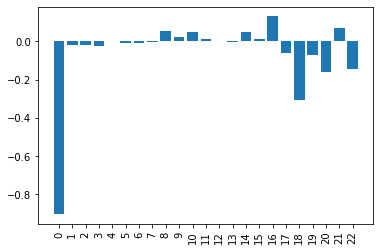

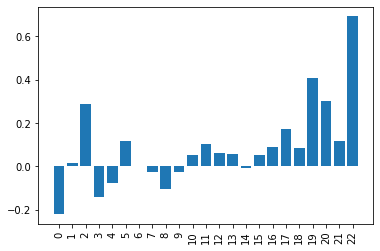

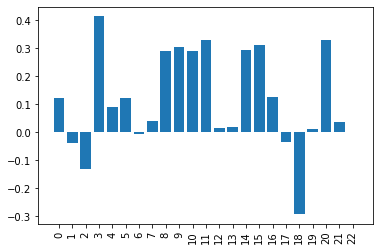

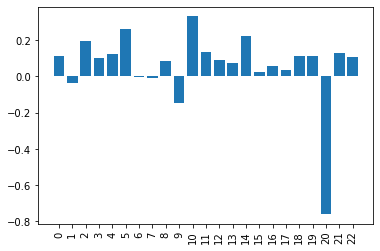

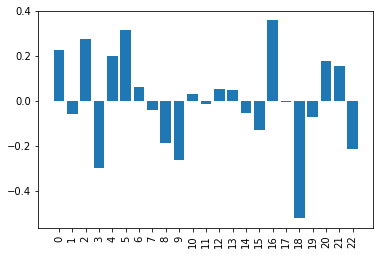

In [72]:
# PCA
pca = PCA()
pca.fit(matrix)
components = pca.components_
variances = pca.explained_variance_
x = [i for i in range(0, len(components[0]))]
for i in range(0, 5):
    print(variances[i])
    plt.figure()
    plt.bar(x, components[i])
    plt.xticks(np.arange(len(components[0])), x, rotation=90)
    # plt.show()
    plt.savefig('Images/Patient' + str(patient) + '/' + 'PCA' + str(i) + '.png')
    print(components[i])